# 1. Installing Library Requirements

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Loading the required Libraries
!pip install pykrige folium rasterio reverse-geocode fuzzywuzzy

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pykrige.ok import OrdinaryKriging

# To train and test models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# To work with raster images
import rasterio
import rasterio.features
import rasterio.transform
import rasterio.mask

import reverse_geocode
from sklearn.metrics import r2_score
from fuzzywuzzy import process

# For plots and figures
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 15.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.4 MB/s eta 0:00:00:00:01


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


/kaggle/input/population-density-and-temperature-raster-2020/gpw_v4_population_density_rev11_2020_30_sec_2020.tif
/kaggle/input/population-density-and-temperature-raster-2020/TEMP.tif
/kaggle/input/global-health-security-intex-2022/Global_health_security_intex_2022.xlsx
/kaggle/input/ebola-dataset/test_points.xlsx
/kaggle/input/ebola-dataset/train_data.xlsx
/kaggle/input/new-temperature-data/TEMP.tif


# 2. Loading Datasets

In [2]:
# Read data:
train_data = pd.read_excel('/kaggle/input/ebola-dataset/train_data.xlsx')

In [3]:
test_data = pd.read_excel('/kaggle/input/ebola-dataset/test_points.xlsx')

In [4]:
# Load the GeoTIFF image
pop_path = "/kaggle/input/population-density-and-temperature-raster-2020/gpw_v4_population_density_rev11_2020_30_sec_2020.tif" 
pop_density_raster = rasterio.open(pop_path)
pop_density_raster

<open DatasetReader name='/kaggle/input/population-density-and-temperature-raster-2020/gpw_v4_population_density_rev11_2020_30_sec_2020.tif' mode='r'>

In [5]:
# Load the GeoTIFF image
temp_path = "/kaggle/input/new-temperature-data/TEMP.tif" 
temp_raster = rasterio.open(temp_path)
temp_raster

<open DatasetReader name='/kaggle/input/new-temperature-data/TEMP.tif' mode='r'>

In [6]:
# Load global health security index data
health_data = pd.read_excel('/kaggle/input/global-health-security-intex-2022/Global_health_security_intex_2022.xlsx')
health_data.rename(columns={'Country': 'country', 'OVERALL SCORE': 'health_security_score'}, inplace=True)
health_data.head(2)


,country,health_security_score
0,Afghanistan,28.8
1,Albania,45.0


# 3. Data Cleaning and Processing

## 3.1 Preparing Training Data

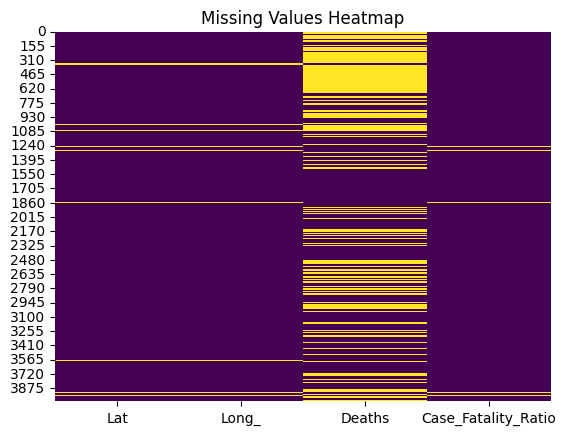

In [7]:
# Visualize missing data
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [8]:
# Drop the rows with no lat-long.
train_data = train_data.dropna(subset=['Lat', 'Long_'])
# Fill Nan cfr with mean values
mean_cfr = train_data['Case_Fatality_Ratio'].mean()
train_data['Case_Fatality_Ratio'].fillna(value=mean_cfr, inplace=True)
# Drop duplicate rows
train_data = train_data.drop_duplicates()

rows, columns = train_data.shape
print(f"Dataset has Rows: {rows}, Columns: {columns}")

# Rename Columns
train_data.rename(columns={'Lat': 'latitude', 'Long_': 'longitude', 'Deaths':'deaths', 
                           'Case_Fatality_Ratio': 'Case_Fatality_Ratio'}, inplace=True)


Dataset has Rows: 3925, Columns: 4


<ipython-input-8-02c2ad0397dd>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Case_Fatality_Ratio'].fillna(value=mean_cfr, inplace=True)


In [9]:
missing_values = train_data.isnull().sum()
missing_values

latitude                  0
longitude                 0
deaths                 1546
Case_Fatality_Ratio       0
dtype: int64

### 3.2.1 Estimating Missing Death Values using Spherical Krigning

In [10]:
# Separate known and unknown deaths
known_deaths = train_data[train_data['deaths'].notnull()]
unknown_deaths = train_data[train_data['deaths'].isnull()]

# Step 2: Kriging for Geospatial Interpolation

lat, lon, deaths = known_deaths['latitude'], known_deaths['longitude'], known_deaths['deaths']

# Kriging for deaths
kriging_model_deaths = OrdinaryKriging(
    lon, lat, deaths, variogram_model="spherical", verbose=False, enable_plotting=False)

missing_locs = unknown_deaths[['latitude', 'longitude']].values
interpolated_deaths, _ = kriging_model_deaths.execute('points', missing_locs[:, 1], missing_locs[:, 0])
unknown_deaths['deaths'] = interpolated_deaths

# Combine interpolated and known deaths
train_data2 = pd.concat([known_deaths, unknown_deaths]).sort_index()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


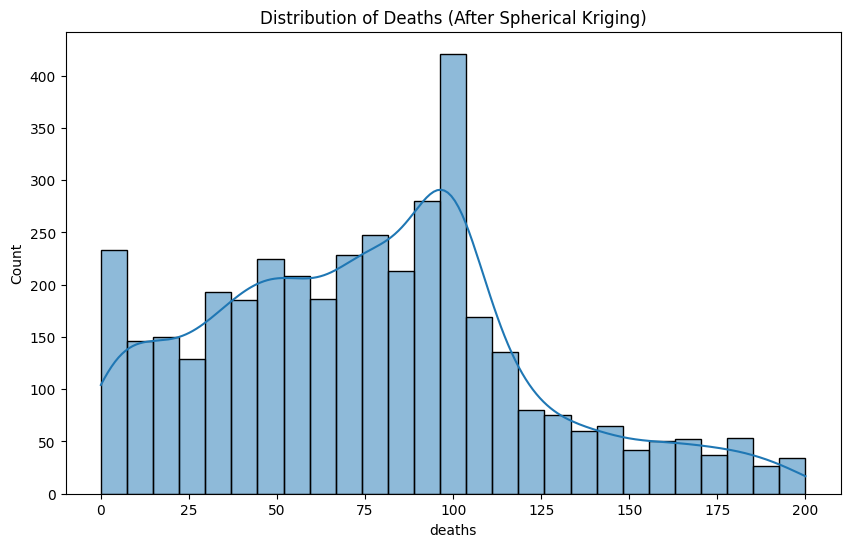

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data2['deaths'], kde=True)
plt.title("Distribution of Deaths (After Spherical Kriging)")
plt.show()

In [12]:
# Calculate RMSE for Kriging predictions
y_true = deaths  # Known deaths
y_pred, _ = kriging_model_deaths.execute("points", lon, lat)  # Predictions for known locations
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE for Spherical Kriging: {rmse}")

RMSE for Spherical Kriging: 2.5046398665469808e-12


In [13]:
train_data2.head(3)

,latitude,longitude,deaths,Case_Fatality_Ratio
0,33.93911,67.709953,79.239684,3.779217
1,41.15330,20.168300,84.847362,1.077234
2,28.03390,1.659600,111.111788,2.536905


### 3.1.2 Adding Population Density, Temperature and Health Security data

In [14]:
# Adding Population Data to training data.
# Used Batch processing instead of direct processing to compute faster.
def batch_population_density(lat_lon_data, raster):
    # Convert latitude and longitude to raster indices
    coords = [(lon, lat) for lat, lon in zip(lat_lon_data["latitude"], lat_lon_data["longitude"])]
    rows_cols = list(map(lambda coord: raster.index(*coord), coords))
    
    # Read the entire raster band into memory for faster access
    raster_data = raster.read(1)
    
    # Extract population density for all points
    population_density = []
    for row, col in rows_cols:
        if 0 <= row < raster.height and 0 <= col < raster.width:  # Check bounds
            population_density.append(raster_data[row, col])
        else:
            population_density.append(np.nan)  # Out of bounds
    
    return population_density

# Process in a batch
train_data2["population_density"] = batch_population_density(train_data2, pop_density_raster)

In [15]:
# Adding temperature Data to training data.
# Used Batch processing instead of direct processing to compute faster.
def batch_temp(lat_lon_data, raster):
    # Convert latitude and longitude to raster indices
    coords = [(lon, lat) for lat, lon in zip(lat_lon_data["latitude"], lat_lon_data["longitude"])]
    rows_cols = list(map(lambda coord: raster.index(*coord), coords))
    
    # Read the entire raster band into memory for faster access
    raster_data = raster.read(1)
    
    # Extract population density for all points
    temperature = []
    for row, col in rows_cols:
        if 0 <= row < raster.height and 0 <= col < raster.width:  # Check bounds
            temperature.append(raster_data[row, col])
        else:
            temperature.append(np.nan)  # Out of bounds
    
    return temperature

# Process in a batch
train_data2["temperature"] = batch_temp(train_data2, temp_raster)

In [16]:
# Function to get country name
def get_country(lat, lon):
    coordinates = [(lat, lon)]
    country = reverse_geocode.search(coordinates)   # Returns a list of dictionaries
    return country[0]['country']     # Extract the country name

# Example: Using pandas for bulk processing

train_data2['country'] = train_data2.apply(lambda row: get_country(row['latitude'], row['longitude']), axis=1)

In [17]:
# Adding health security data to training data
# Function to find best fuzzy match for a country name
# Create a lookup dictionary from health_data
health_dict = dict(zip(health_data['country'], health_data['health_security_score']))

# Function to find the best match and return health_security_index
def get_health_score(country, choices_dict, threshold=80):
    match, score = process.extractOne(country, list(choices_dict.keys()))
    return choices_dict[match] if score >= threshold else None  # Return index if confidence is high

# Apply fuzzy matching and retrieve health index
train_data2['health_security_score'] = train_data2['country'].apply(lambda x: get_health_score(x, health_dict))
train_data2.head()

,latitude,longitude,deaths,Case_Fatality_Ratio,population_density,temperature,country,health_security_score
0,33.93911,67.709953,79.239684,3.779217,12.849034,-0.8125,Afghanistan,28.8
1,41.15330,20.168300,84.847362,1.077234,113.237946,14.3125,Albania,45.0
2,28.03390,1.659600,111.111788,2.536905,1.407658,24.9375,Algeria,26.2
3,42.50630,1.521800,165.000000,0.345543,2241.784180,10.9375,Andorra,34.7
4,-11.20270,17.873900,109.781647,1.836434,2.204391,22.5000,Angola,29.1


In [18]:
# Feature Engineering
# Adding distance from the epicenter as an example feature
epicenter_lat, epicenter_lon = lat.mean(), lon.mean()
train_data2['distance_from_epicenter'] = np.sqrt(
    (train_data2['latitude'] - epicenter_lat)**2 + 
    (train_data2['longitude'] - epicenter_lon)**2)

In [19]:
train_data2.head()

,latitude,longitude,deaths,Case_Fatality_Ratio,population_density,temperature,country,health_security_score,distance_from_epicenter
0,33.93911,67.709953,79.239684,3.779217,12.849034,-0.8125,Afghanistan,28.8,153.436720
1,41.15330,20.168300,84.847362,1.077234,113.237946,14.3125,Albania,45.0,105.924580
2,28.03390,1.659600,111.111788,2.536905,1.407658,24.9375,Algeria,26.2,87.845108
3,42.50630,1.521800,165.000000,0.345543,2241.784180,10.9375,Andorra,34.7,87.361732
4,-11.20270,17.873900,109.781647,1.836434,2.204391,22.5000,Angola,29.1,114.385298


In [20]:
train_data2.describe()

,latitude,longitude,deaths,Case_Fatality_Ratio,population_density,temperature,health_security_score,distance_from_epicenter
count,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3912.000000,3811.000000,3925.000000
mean,35.736183,-71.109728,76.241816,1.589198,310.995636,13.761791,71.107531,31.331616
std,13.441327,55.361480,45.215019,9.834535,1925.036255,5.917215,11.443366,49.788466
min,-71.949900,-178.116500,0.000000,0.000000,-9999.000000,-14.000000,16.000000,0.167653
25%,33.191535,-96.595639,42.000000,0.901882,1.446099,9.687500,75.900000,6.323425
50%,37.895700,-86.717326,76.387366,1.288520,13.101657,13.500000,75.900000,11.255780
75%,42.176955,-77.357900,101.372941,1.740644,99.009583,17.812500,75.900000,26.875590
max,71.706900,178.065000,200.000000,600.000000,32334.808594,30.125000,75.900000,272.074593


### 3.1.3 Adding Confirmed Cases

In [21]:
training_data_cc = train_data2
cfr_mean = training_data_cc['Case_Fatality_Ratio'].mean()
# Define the range for valid CFR values
cfr_min = 0
cfr_max = 100

# Replace cfr outliers with the mean
training_data_cc['Case_Fatality_Ratio'] = np.where(
    (training_data_cc['Case_Fatality_Ratio'] < cfr_min) | (training_data_cc['Case_Fatality_Ratio'] > cfr_max),
    100,  # Replace with mean
    training_data_cc['Case_Fatality_Ratio']
)
training_data_cc.describe()

,latitude,longitude,deaths,Case_Fatality_Ratio,population_density,temperature,health_security_score,distance_from_epicenter
count,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3912.000000,3811.000000,3925.000000
mean,35.736183,-71.109728,76.241816,1.452689,310.995636,13.761791,71.107531,31.331616
std,13.441327,55.361480,45.215019,2.405771,1925.036255,5.917215,11.443366,49.788466
min,-71.949900,-178.116500,0.000000,0.000000,-9999.000000,-14.000000,16.000000,0.167653
25%,33.191535,-96.595639,42.000000,0.901882,1.446099,9.687500,75.900000,6.323425
50%,37.895700,-86.717326,76.387366,1.288520,13.101657,13.500000,75.900000,11.255780
75%,42.176955,-77.357900,101.372941,1.740644,99.009583,17.812500,75.900000,26.875590
max,71.706900,178.065000,200.000000,100.000000,32334.808594,30.125000,75.900000,272.074593


In [22]:

training_data_cc['confirmed_cases'] = (training_data_cc['deaths']*100)/training_data_cc['Case_Fatality_Ratio']

# Replace Nan values
training_data_cc['confirmed_cases'] = training_data_cc['confirmed_cases'].interpolate(method='linear')

# Replace infinite values with NaN
training_data_cc = training_data_cc.replace([np.inf, -np.inf], np.nan)

# Interpolate using linear method
training_data_cc = training_data_cc.interpolate(method='linear')
missing_values3 = training_data_cc.isnull().sum()
missing_values3

<ipython-input-22-6b7ecc0c5d02>:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  training_data_cc = training_data_cc.interpolate(method='linear')


latitude                   0
longitude                  0
deaths                     0
Case_Fatality_Ratio        0
population_density         0
temperature                0
country                    0
health_security_score      0
distance_from_epicenter    0
confirmed_cases            0
dtype: int64

In [23]:
# # Check for infinite values in a specific column
# if np.isinf(training_data_cc['confirmed_cases']).any():
#     print("Column 'A' contains infinite values.")
# else:
#     print("Column 'A' does not contain infinite values.")

In [24]:
# Removing NAN Values
training_data_cc['health_security_score'] = training_data_cc['health_security_score'].interpolate(method='linear')
training_data_cc['temperature'] = training_data_cc['temperature'].interpolate(method='linear')
training_data_cc.head()

,latitude,longitude,deaths,Case_Fatality_Ratio,population_density,temperature,country,health_security_score,distance_from_epicenter,confirmed_cases
0,33.93911,67.709953,79.239684,3.779217,12.849034,-0.8125,Afghanistan,28.8,153.436720,2096.722406
1,41.15330,20.168300,84.847362,1.077234,113.237946,14.3125,Albania,45.0,105.924580,7876.411757
2,28.03390,1.659600,111.111788,2.536905,1.407658,24.9375,Algeria,26.2,87.845108,4379.816445
3,42.50630,1.521800,165.000000,0.345543,2241.784180,10.9375,Andorra,34.7,87.361732,47751.000000
4,-11.20270,17.873900,109.781647,1.836434,2.204391,22.5000,Angola,29.1,114.385298,5977.980419


In [25]:
# Compute mean and standard deviation
pd_mean = training_data_cc['population_density'].mean()
pd_std_dev = training_data_cc['population_density'].std()

# Define the threshold (2.5 standard deviations)
lower_bound = pd_mean - 1.96 * pd_std_dev
upper_bound = pd_mean + 1.96 * pd_std_dev

# Replace outliers with the mean
training_data_cc['population_density'] = np.where(
    (training_data_cc['population_density'] < lower_bound) | (training_data_cc['population_density'] > upper_bound),
    pd_mean,  # Replace with mean
    training_data_cc['population_density']  # Keep original value if within bounds
)
training_data_cc.isnull().sum()

latitude                   0
longitude                  0
deaths                     0
Case_Fatality_Ratio        0
population_density         0
temperature                0
country                    0
health_security_score      0
distance_from_epicenter    0
confirmed_cases            0
dtype: int64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


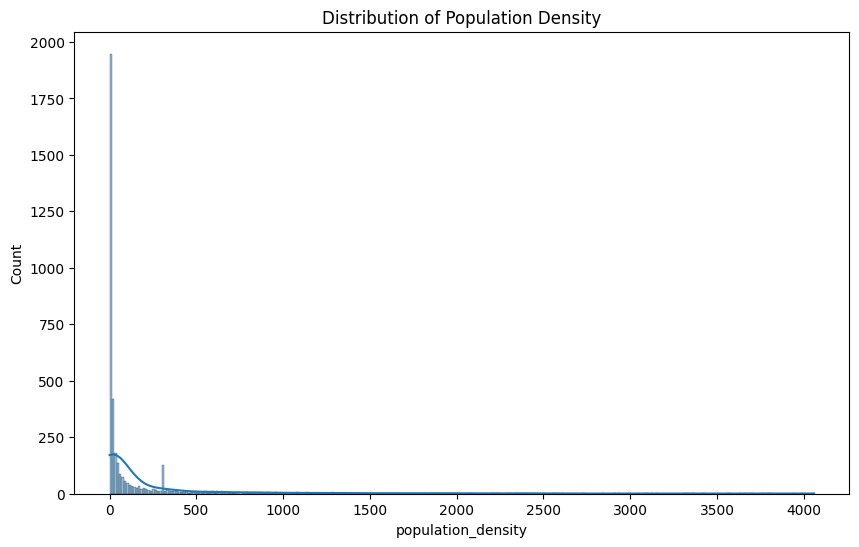

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(training_data_cc['population_density'], kde=True)
plt.title("Distribution of Population Density")
plt.show()

Output the Cleaned and processed training data.

In [27]:
training_data_cc.to_csv('trainig_data_cc.csv', index=False)

## 3.2 Preparing Test data

In [28]:
test_data = test_data.dropna()
test_data = test_data.drop_duplicates()

rows, columns = test_data.shape
print(f"Dataset has Rows: {rows}, Columns: {columns}")

test_data.rename(columns={'Lat': 'latitude', 'Long_': 'longitude'}, inplace=True)

test_data2 = test_data

missing_values2 = test_data2.isnull().sum()
missing_values2

Dataset has Rows: 981, Columns: 2


latitude     0
longitude    0
dtype: int64

### 3.2.1 Adding Population Density, Temperature and Health Security data

In [29]:
# TEST DATA 
# Used Batch processing instead of direct processing to compute faster.
def batch_population_density(lat_lon_data, raster):
    # Convert latitude and longitude to raster indices
    coords = [(lon, lat) for lat, lon in zip(lat_lon_data["latitude"], lat_lon_data["longitude"])]
    rows_cols = list(map(lambda coord: raster.index(*coord), coords))
    
    # Read the entire raster band into memory for faster access
    raster_data = raster.read(1)
    
    # Extract population density for all points
    population_density = []
    for row, col in rows_cols:
        if 0 <= row < raster.height and 0 <= col < raster.width:  # Check bounds
            population_density.append(raster_data[row, col])
        else:
            population_density.append(np.nan)  # Out of bounds
    
    return population_density

# Process in a batch
test_data2["population_density"] = batch_population_density(test_data2, pop_density_raster)


In [30]:
# TEST DATA
# Used Batch processing instead of direct processing to compute faster.
def batch_temp(lat_lon_data, raster):
    # Convert latitude and longitude to raster indices
    coords = [(lon, lat) for lat, lon in zip(lat_lon_data["latitude"], lat_lon_data["longitude"])]
    rows_cols = list(map(lambda coord: raster.index(*coord), coords))
    
    # Read the entire raster band into memory for faster access
    raster_data = raster.read(1)
    
    # Extract population density for all points
    temperature = []
    for row, col in rows_cols:
        if 0 <= row < raster.height and 0 <= col < raster.width:  # Check bounds
            temperature.append(raster_data[row, col])
        else:
            temperature.append(np.nan)  # Out of bounds
    
    return temperature

# Process in a batch
test_data2["temperature"] = batch_temp(test_data2, temp_raster)


In [31]:
# TEST DATA
# Function to get country name
def get_country(lat, lon):
    coordinates = [(lat, lon)]
    country = reverse_geocode.search(coordinates)   # Returns a list of dictionaries
    return country[0]['country']     # Extract the country name

# Example: Using pandas for bulk processing

test_data2['country'] = test_data2.apply(lambda row: get_country(row['latitude'], row['longitude']), axis=1)
test_data2.head(1)

,latitude,longitude,population_density,temperature,country
0,41.1533,20.1683,113.237946,14.3125,Albania


In [32]:
# TEST DATA
health_dict = dict(zip(health_data['country'], health_data['health_security_score']))

# Function to find the best match and return health_security_index
def get_health_score(country, choices_dict, threshold=80):
    match, score = process.extractOne(country, list(choices_dict.keys()))
    return choices_dict[match] if score >= threshold else None  # Return index if confidence is high

# Apply fuzzy matching and retrieve health index
test_data2['health_security_score'] = test_data2['country'].apply(lambda x: get_health_score(x, health_dict))
test_data2.head(4)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,latitude,longitude,population_density,temperature,country,health_security_score
0,41.1533,20.1683,113.237946,14.3125,Albania,45.0
1,-71.9499,23.3470,-9999.000000,NaN,South Africa,45.8
2,-35.4735,149.0124,1.007329,11.7500,Australia,71.1
3,-34.9285,138.6007,2557.692871,16.1875,Australia,71.1


In [33]:
# Step 6: Predict for Test Data
test_data2['distance_from_epicenter'] = np.sqrt(
    (test_data2['latitude'] - epicenter_lat)**2 + 
    (test_data2['longitude'] - epicenter_lon)**2
)

In [34]:
test_data2.describe()

,latitude,longitude,population_density,temperature,health_security_score,distance_from_epicenter
count,981.000000,981.000000,981.000000,977.000000,955.000000,981.000000
mean,35.619019,-70.370781,310.443512,13.750448,70.850471,31.958147
std,13.846984,56.453781,2193.419922,5.943451,11.989567,50.934537
min,-71.949900,-175.198200,-9999.000000,-9.375000,16.000000,0.431361
25%,33.086588,-96.326056,1.127449,9.562500,75.900000,6.160580
50%,37.940907,-86.845176,13.883896,13.437500,75.900000,11.100948
75%,42.248070,-77.103699,110.201477,17.875000,75.900000,27.088533
max,66.830900,177.649300,31440.013672,28.812500,75.900000,272.074593


In [35]:
missing_values5 = test_data2.isnull().sum()
missing_values5

latitude                    0
longitude                   0
population_density          0
temperature                 4
country                     0
health_security_score      26
distance_from_epicenter     0
dtype: int64

In [36]:
# Removing NAN Values
test_data2['health_security_score'] = test_data2['health_security_score'].interpolate(method='linear')
test_data2['temperature'] = test_data2['temperature'].interpolate(method='linear')
test_data2.head()

,latitude,longitude,population_density,temperature,country,health_security_score,distance_from_epicenter
0,41.1533,20.1683,113.237946,14.31250,Albania,45.0,105.924580
1,-71.9499,23.3470,-9999.000000,13.03125,South Africa,45.8,154.397192
2,-35.4735,149.0124,1.007329,11.75000,Australia,71.1,245.743705
3,-34.9285,138.6007,2557.692871,16.18750,Australia,71.1,235.652294
4,47.5162,14.5501,23.741051,4.68750,Austria,56.9,100.751312


In [37]:
# Compute mean and standard deviation
pd_mean = test_data2['population_density'].mean()
pd_std_dev = test_data2['population_density'].std()

# Define the threshold (2.5 standard deviations)
lower_bound = pd_mean - 1.96 * pd_std_dev
upper_bound = pd_mean + 1.96 * pd_std_dev

# Replace outliers with the mean
test_data2['population_density'] = np.where(
    (test_data2['population_density'] < lower_bound) | (test_data2['population_density'] > upper_bound),
    pd_mean,  # Replace with mean
    test_data2['population_density']  # Keep original value if within bounds
)
test_data2.isnull().sum()

latitude                   0
longitude                  0
population_density         0
temperature                0
country                    0
health_security_score      0
distance_from_epicenter    0
dtype: int64

Output the cleaned and processed test data.

In [38]:
test_data2.to_csv('test_data_prepared.csv', index=False)

# 4. Visualizations

In [39]:
# Create 2D density plot
fig = ff.create_2d_density(
    x=train_data2["longitude"], 
    y=train_data2["latitude"], 
    colorscale="Viridis"
)

# Update layout with labels
fig.update_layout(
    title="Geographic Density of Deaths",
    xaxis_title="Longitude",
    yaxis_title="Latitude",
    coloraxis_colorbar=dict(title="Density")  # Label for the color bar
)
# Show plot
fig.show()

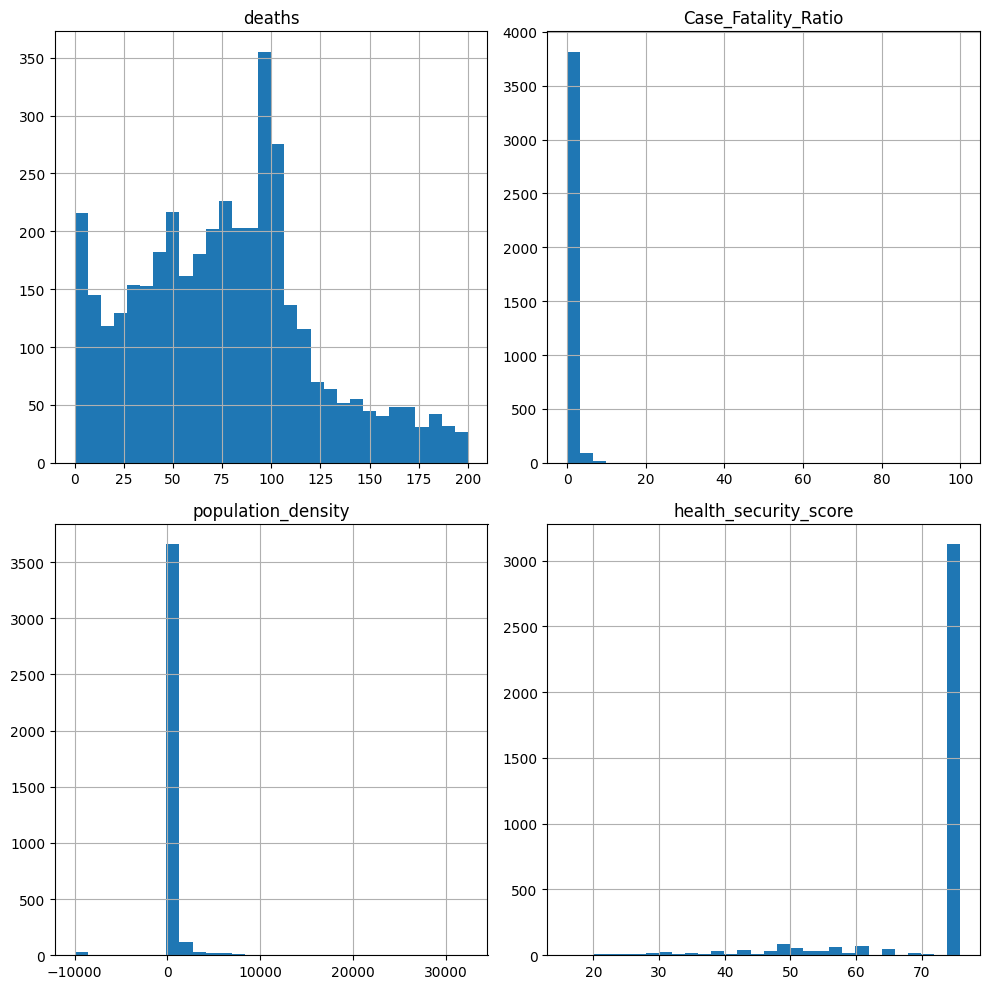

In [40]:
train_data2[['deaths', 'Case_Fatality_Ratio', 'population_density','health_security_score']].hist(bins=30, figsize=(10, 10))
plt.tight_layout()
plt.show()

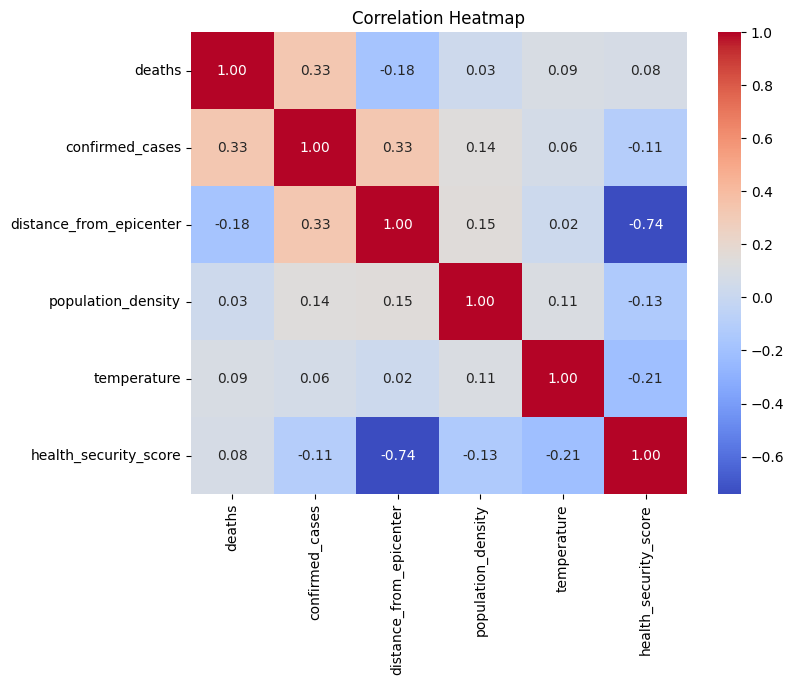

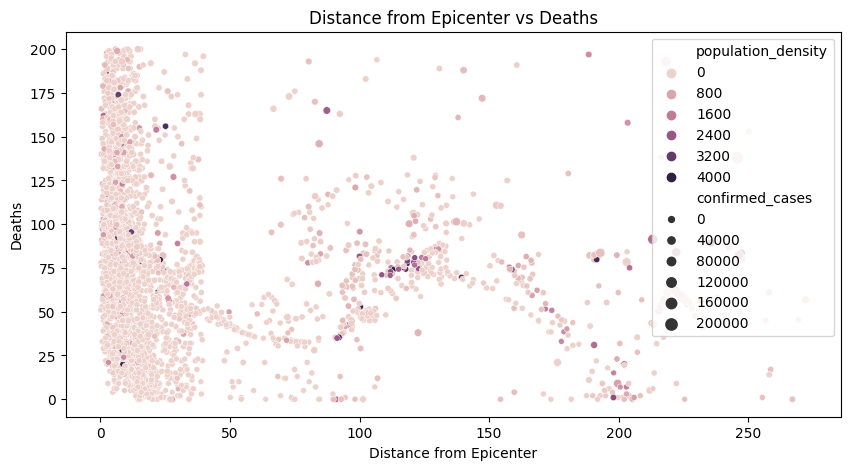

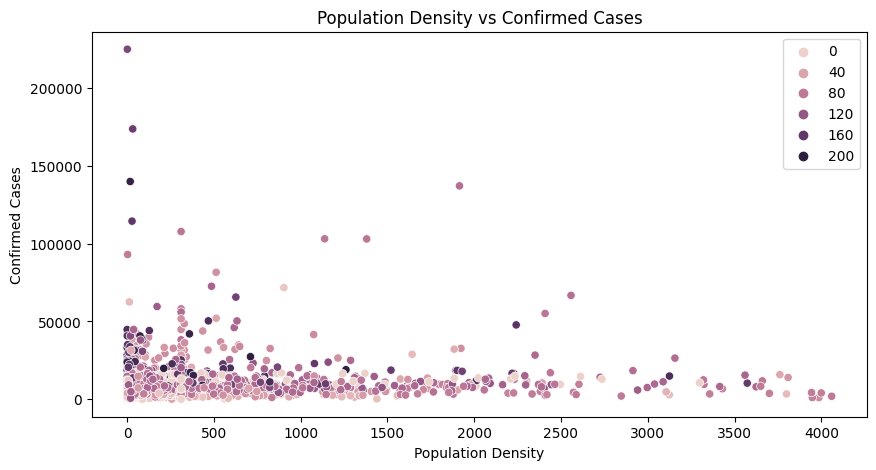

In [41]:
correlation_features = ['deaths', 'confirmed_cases', 'distance_from_epicenter','population_density', 'temperature', 'health_security_score']
if all(col in training_data_cc.columns for col in correlation_features):
    corr_matrix = training_data_cc[correlation_features].corr()
    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

    # Key Correlation Plots
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=training_data_cc, x='distance_from_epicenter', y='deaths', hue='population_density', size='confirmed_cases')
    plt.title("Distance from Epicenter vs Deaths")
    plt.xlabel("Distance from Epicenter")
    plt.ylabel("Deaths")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=training_data_cc, x='population_density', y='confirmed_cases', hue='deaths')
    plt.title("Population Density vs Confirmed Cases")
    plt.xlabel("Population Density")
    plt.ylabel("Confirmed Cases")
    plt.legend()
    plt.show()

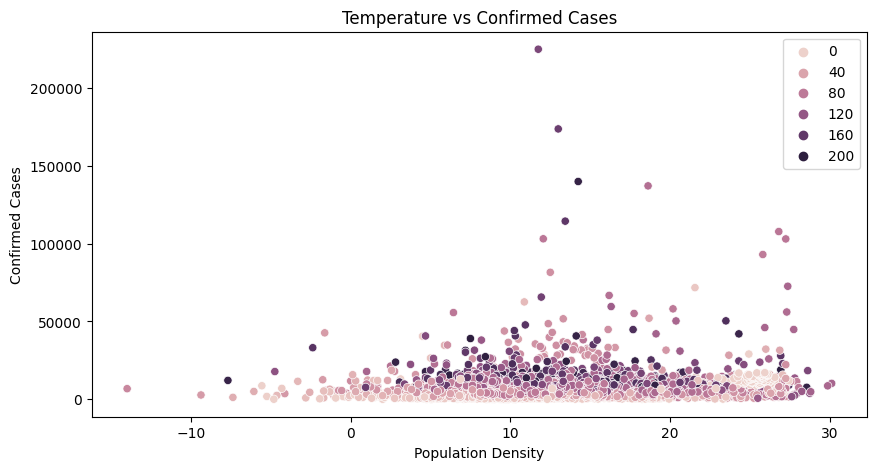

In [42]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=training_data_cc, x='temperature', y='confirmed_cases', hue='deaths')
plt.title("Temperature vs Confirmed Cases")
plt.xlabel("Population Density")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

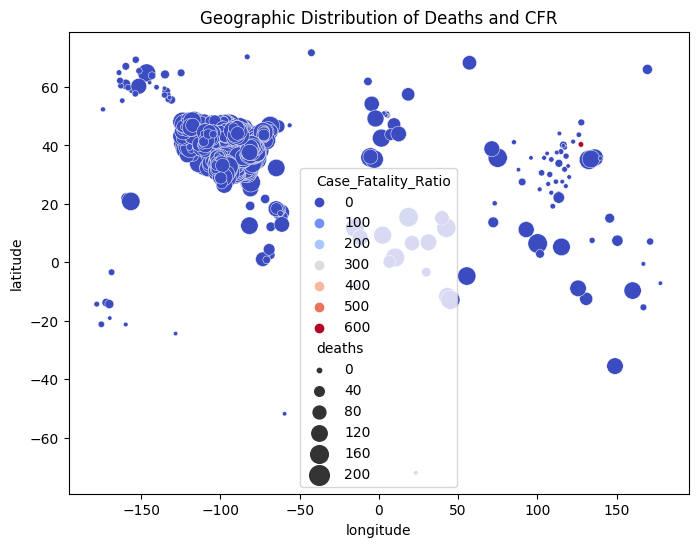

In [43]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', size='deaths', hue='Case_Fatality_Ratio', data=train_data, sizes=(10, 200), palette='coolwarm')
plt.title('Geographic Distribution of Deaths and CFR')
plt.show()

In [44]:
# # Geospatial Map- Generate a map of deaths
# map_ebola = folium.Map(location=[training_data_cc['latitude'].mean(), training_data_cc['longitude'].mean()], zoom_start=6)

# for _, row in known_data.iterrows():
#     folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=row['deaths'] / 1000,  # Adjust for scale
#         color='red',
#         fill=True,
#         fill_opacity=0.6,
#         tooltip=f"Deaths: {row['deaths']}, Cases: {row['confirmed_cases']}"
#     ).add_to(map_ebola)

# map_ebola.save("ebola_map.html")
# print("Geospatial map saved as ebola_map.html")

# 5. Training the Model Using Gradient XGBoost for death prediction

In [67]:
# Features for the model
features_death1 = ['latitude', 'longitude', 'distance_from_epicenter']

# Step 4: Gradient Boosting for Deaths Prediction
# Prepare features and target
X = training_data_cc[features_death1]
y_deaths = training_data_cc['deaths']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_deaths, test_size=0.2, random_state=42)

# Initialize and train XGBoost model
xgb_deaths = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_deaths.fit(X_train, y_train)

# Predict and evaluate
y_pred_deaths = xgb_deaths.predict(X_test)
rmse_deaths = np.sqrt(mean_squared_error(y_test, y_pred_deaths))
print(f"Deaths RMSE after XGBoost training: {rmse_deaths}")
r2 = r2_score(y_test, y_pred_deaths)
print(f'R² Score: {r2:.4f}')

Deaths RMSE after XGBoost training: 33.48256768878324
R² Score: 0.4116


**Result**: The best RMSE for deaths is 33.4285

# 6. Training the model Using XGBoost for Confirmed Cases Prediction

In [69]:
# Step 5: Gradient Boosting for Confirmed Cases Prediction
# Features for the model
features_cc2 = ['latitude', 'longitude', 'distance_from_epicenter','deaths', 'health_security_score', 'temperature']
X_cc = training_data_cc[features_cc2]
y_cc = training_data_cc['confirmed_cases']
    
# Train-test split
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_cc, y_cc, test_size=0.2, random_state=42)
    
# Initialize and train XGBoost model
xgb_cc = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_cc.fit(X_train_cc, y_train_cc)
    
# Predict and evaluate
y_pred_cc = xgb_cc.predict(X_test_cc)
rmse_cc = np.sqrt(mean_squared_error(y_test_cc, y_pred_cc))
print(f"Confirmed Cases RMSE: {rmse_cc}")

r2 = r2_score(y_test_cc, y_pred_cc)
print(f'R² Score: {r2:.4f}')

Confirmed Cases RMSE: 5240.593736560157
R² Score: 0.7290


**Result**: The best RMSE for the confirmed cases is 5260.7377.

# 7. Test Data Death Predictions

In [49]:
# Predict deaths
test_data2['deaths'] = xgb_deaths.predict(test_data2[features_death2])
test_data2.head(2)

,latitude,longitude,population_density,temperature,country,health_security_score,distance_from_epicenter,deaths
0,41.1533,20.1683,113.237946,14.31250,Albania,45.0,105.924580,79.855370
1,-71.9499,23.3470,310.443512,13.03125,South Africa,45.8,154.397192,25.022238


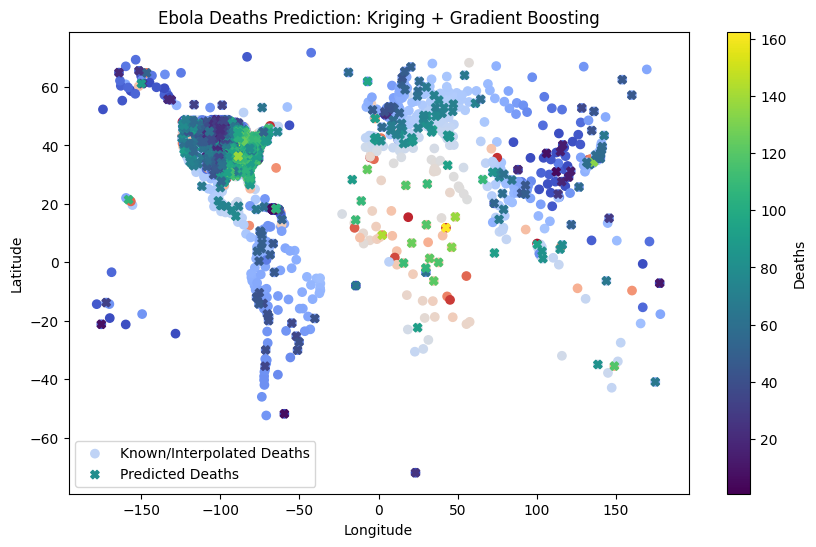

In [50]:
# Visualize predictions 
plt.figure(figsize=(10, 6))
plt.scatter(training_data_cc['longitude'], training_data_cc['latitude'], c=training_data_cc['deaths'], cmap='coolwarm', label='Known/Interpolated Deaths')
plt.scatter(test_data2['longitude'], test_data2['latitude'], c=test_data2['deaths'], cmap='viridis', marker='X', label='Predicted Deaths')
plt.colorbar(label='Deaths')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ebola Deaths Prediction: Kriging + Gradient Boosting')
plt.legend()
plt.show()

# 8. Test Data Confirmed cases Prediction

In [51]:
# Predict confirmed deaths
test_data3 = test_data2
test_data3['predicted_confirmed_cases'] = xgb_cc.predict(test_data3[features_cc2])
test_data3.head()

,latitude,longitude,population_density,temperature,country,health_security_score,distance_from_epicenter,deaths,predicted_confirmed_cases
0,41.1533,20.1683,113.237946,14.31250,Albania,45.0,105.924580,79.855370,8510.173828
1,-71.9499,23.3470,310.443512,13.03125,South Africa,45.8,154.397192,25.022238,6701.768066
2,-35.4735,149.0124,1.007329,11.75000,Australia,71.1,245.743705,118.630188,217567.468750
3,-34.9285,138.6007,2557.692871,16.18750,Australia,71.1,235.652294,83.463280,54117.648438
4,47.5162,14.5501,23.741051,4.68750,Austria,56.9,100.751312,65.081451,13024.681641


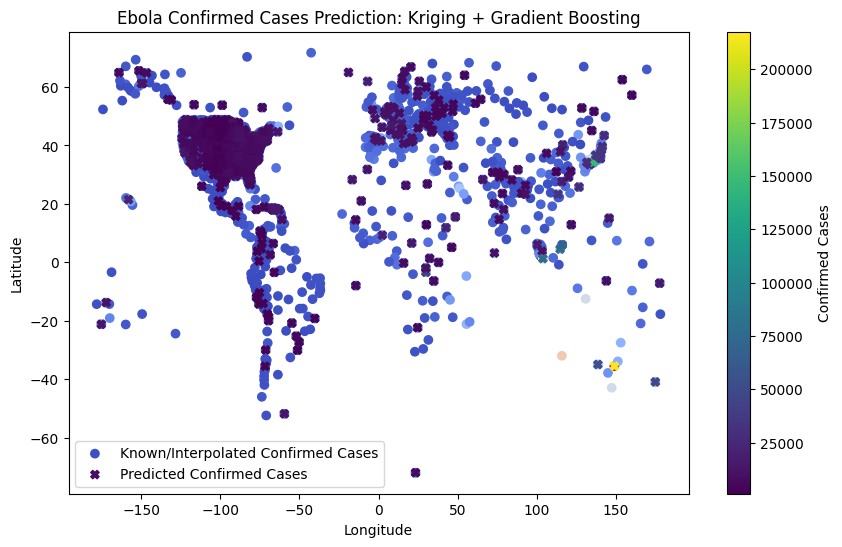

In [52]:
# Visualize predictions 
plt.figure(figsize=(10, 6))
plt.scatter(training_data_cc['longitude'], training_data_cc['latitude'], c=training_data_cc['confirmed_cases'], cmap='coolwarm', label='Known/Interpolated Confirmed Cases')
plt.scatter(test_data2['longitude'], test_data2['latitude'], c=test_data2['predicted_confirmed_cases'], cmap='viridis', marker='X', label='Predicted Confirmed Cases')
plt.colorbar(label='Confirmed Cases')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ebola Confirmed Cases Prediction: Kriging + Gradient Boosting')
plt.legend()
plt.show()

# 9. Output the results

## 9.1 Calculating the CFR using confirmed cases and deaths.

In [53]:
test_data3['Case_Fatality_Ratio'] = test_data3['deaths']*100/test_data3['predicted_confirmed_cases']
test_data3.head()

,latitude,longitude,population_density,temperature,country,health_security_score,distance_from_epicenter,deaths,predicted_confirmed_cases,Case_Fatality_Ratio
0,41.1533,20.1683,113.237946,14.31250,Albania,45.0,105.924580,79.855370,8510.173828,0.938352
1,-71.9499,23.3470,310.443512,13.03125,South Africa,45.8,154.397192,25.022238,6701.768066,0.373368
2,-35.4735,149.0124,1.007329,11.75000,Australia,71.1,245.743705,118.630188,217567.468750,0.054526
3,-34.9285,138.6007,2557.692871,16.18750,Australia,71.1,235.652294,83.463280,54117.648438,0.154226
4,47.5162,14.5501,23.741051,4.68750,Austria,56.9,100.751312,65.081451,13024.681641,0.499678


In [54]:
test_data3.describe()

,latitude,longitude,population_density,temperature,health_security_score,distance_from_epicenter,deaths,predicted_confirmed_cases,Case_Fatality_Ratio
count,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000
mean,35.619019,-70.370781,199.493057,13.727001,70.837360,31.958147,76.359352,7865.091309,1.221051
std,13.846984,56.453781,505.796143,5.946267,11.979644,50.934537,31.437742,10037.055664,0.524992
min,-71.949900,-175.198200,0.000000,-9.375000,16.000000,0.431361,0.838337,995.902893,0.006359
25%,33.086588,-96.326056,1.333909,9.562500,75.900000,6.160580,53.143433,4666.226074,0.997254
50%,37.940907,-86.845176,14.868243,13.437500,75.900000,11.100948,80.885925,7005.223633,1.231478
75%,42.248070,-77.103699,122.068199,17.812500,75.900000,27.088533,100.260307,8726.320312,1.454327
max,66.830900,177.649300,4295.216309,28.812500,75.900000,272.074593,162.470169,217567.468750,5.112071


In [55]:
test_data3.to_csv('test_data_results.csv', index=False)

In [56]:
# Geospatial Map- Generate a map of deaths
map_ebola_deaths = folium.Map(location=[test_data3['latitude'].mean(), test_data3['longitude'].mean()], zoom_start=6)

for _, row in test_data3.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['deaths'] / 1000,  # Adjust for scale
        color='red',
        fill=True,
        fill_opacity=0.6,
        tooltip=f"Deaths: {row['deaths']}, Cases: {row['predicted_confirmed_cases']}"
    ).add_to(map_ebola_deaths)

map_ebola_deaths.save("ebola_map.html")
print("Geospatial map saved as ebola_map.html")

Geospatial map saved as ebola_map.html


# 9.2 Model Finished

# 10. Scroll to see results from other Training models

## 10.1 Tree-Based Models (Non-Linear)

In [57]:
# For Deaths
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Initialize models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
catboost = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0)

# Train models
rf.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_lgbm = lgbm.predict(X_test)
y_pred_catboost = catboost.predict(X_test)

# Evaluate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

print("RF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("LGBM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_catboost)))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 3140, number of used features: 5
[LightGBM] [Info] Start training from score 76.296802
RF RMSE: 34.84145466571236
LGBM RMSE: 33.57833604873854
CatBoost RMSE: 33.811406678347154


In [58]:
# For Confirmed Cases
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Initialize models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
catboost = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0)

# Train models
rf.fit(X_train_cc, y_train_cc)
lgbm.fit(X_train_cc, y_train_cc)
catboost.fit(X_train_cc, y_train_cc)

# Predictions
y_pred_rf = rf.predict(X_test_cc)
y_pred_lgbm = lgbm.predict(X_test_cc)
y_pred_catboost = catboost.predict(X_test_cc)

# Evaluate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

print("RF RMSE:", np.sqrt(mean_squared_error(y_test_cc, y_pred_rf)))
print("LGBM RMSE:", np.sqrt(mean_squared_error(y_test_cc, y_pred_lgbm)))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test_cc, y_pred_catboost)))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1337
[LightGBM] [Info] Number of data points in the train set: 3140, number of used features: 6
[LightGBM] [Info] Start training from score 7694.701827
RF RMSE: 5693.5908038090965
LGBM RMSE: 6278.506689913274
CatBoost RMSE: 5299.47359478466


## 10.2 Deep Learning: Neural Networks (MLP Regressor / TensorFlow/Keras)

In [59]:
# Deep Learning - Deaths
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))


MLP RMSE: 35.39647818274139


In [60]:
# Deep Learning- Confirmed Cases
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42)
mlp.fit(X_train_cc, y_train_cc)
y_pred_mlp = mlp.predict(X_test_cc)

print("MLP RMSE:", np.sqrt(mean_squared_error(y_test_cc, y_pred_mlp)))


MLP RMSE: 6552.653246053131


## 10.3 Ensemble Models (Combining Predictions)

In [61]:
# For Deaths
from sklearn.ensemble import StackingRegressor, VotingRegressor

estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=100, random_state=42)),
    ('catboost', CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0))
]

stack = StackingRegressor(estimators=estimators, final_estimator=LGBMRegressor())
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)

print("Stacking RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_stack)))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 3140, number of used features: 5
[LightGBM] [Info] Start training from score 76.296802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 2512, number of used features: 5
[LightGBM] [Info] Start training from score 76.614913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 2512, number of used features: 5
[LightGBM] [Info] Start trainin

In [62]:
# For Confirmed Cases
from sklearn.ensemble import StackingRegressor, VotingRegressor

estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=100, random_state=42)),
    ('catboost', CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0))
]

stack = StackingRegressor(estimators=estimators, final_estimator=LGBMRegressor())
stack.fit(X_train_cc, y_train_cc)
y_pred_stack = stack.predict(X_test_cc)

print("Stacking RMSE:", np.sqrt(mean_squared_error(y_test_cc, y_pred_stack)))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1337
[LightGBM] [Info] Number of data points in the train set: 3140, number of used features: 6
[LightGBM] [Info] Start training from score 7694.701827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 2512, number of used features: 6
[LightGBM] [Info] Start training from score 7819.074037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 2512, number of used features: 6
[LightGBM] [Info] Start tra

## 10.4 Random Forest

In [63]:
# For Deaths

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Compute RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Random Forest RMSE: {rmse:.4f}')

# Feature Importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

Random Forest RMSE: 33.8552
                   Feature  Importance
2  distance_from_epicenter    0.370245
0                 latitude    0.209564
1                longitude    0.178343
3       population_density    0.176363
4    health_security_score    0.065486


In [64]:
# For Confirmed Cases
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_cc, y_train_cc)

# Make predictions
y_pred = rf.predict(X_test_cc)

# Compute RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_cc, y_pred))
print(f'Random Forest RMSE: {rmse:.4f}')


Random Forest RMSE: 5689.0722
